In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Tabular models

In [3]:
from fastai.tabular import *

Tabular data should be in a Pandas `DataFrame`.

In [4]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')

Understand the data from adult sample a little more.

In [5]:
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k
5,20,Private,63210,HS-grad,9.0,Never-married,Handlers-cleaners,Own-child,White,Male,0,0,15,United-States,<50k
6,49,Private,44434,Some-college,10.0,Divorced,NaN,Other-relative,White,Male,0,0,35,United-States,<50k
7,37,Private,138940,11th,7.0,Married-civ-spouse,NaN,Husband,White,Male,0,0,40,United-States,<50k
8,46,Private,328216,HS-grad,9.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>=50k
9,36,Self-emp-inc,216711,HS-grad,NaN,Married-civ-spouse,NaN,Husband,White,Male,99999,0,50,?,>=50k


In [6]:
df.info

<bound method DataFrame.info of        age          workclass  fnlwgt  ... hours-per-week  native-country salary
0       49            Private  101320  ...             40   United-States  >=50k
1       44            Private  236746  ...             45   United-States  >=50k
2       38            Private   96185  ...             32   United-States   <50k
3       38       Self-emp-inc  112847  ...             40   United-States  >=50k
4       42   Self-emp-not-inc   82297  ...             50   United-States   <50k
...    ...                ...     ...  ...            ...             ...    ...
32556   36            Private  297449  ...             40   United-States  >=50k
32557   23                  ?  123983  ...             40   United-States   <50k
32558   53            Private  157069  ...             40   United-States  >=50k
32559   32          Local-gov  217296  ...             22   United-States   <50k
32560   26            Private  182308  ...             40   United-States   <

In [7]:
df.describe

<bound method NDFrame.describe of        age          workclass  fnlwgt  ... hours-per-week  native-country salary
0       49            Private  101320  ...             40   United-States  >=50k
1       44            Private  236746  ...             45   United-States  >=50k
2       38            Private   96185  ...             32   United-States   <50k
3       38       Self-emp-inc  112847  ...             40   United-States  >=50k
4       42   Self-emp-not-inc   82297  ...             50   United-States   <50k
...    ...                ...     ...  ...            ...             ...    ...
32556   36            Private  297449  ...             40   United-States  >=50k
32557   23                  ?  123983  ...             40   United-States   <50k
32558   53            Private  157069  ...             40   United-States  >=50k
32559   32          Local-gov  217296  ...             22   United-States   <50k
32560   26            Private  182308  ...             40   United-States  

In [8]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'salary'],
      dtype='object')

Checking for correlations between data.

In [10]:
df[['salary','age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']].corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036382,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043288,0.000432,-0.010252,-0.018768
education-num,0.036382,-0.043288,1.000000,0.122362,0.079449,0.147557
capital-gain,0.077674,0.000432,0.122362,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079449,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.147557,0.078409,0.054256,1.000000


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Graph for workclass: total = 9


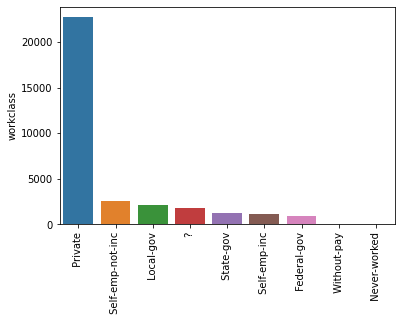

Graph for education: total = 16


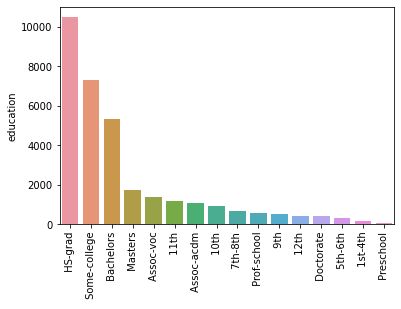

Graph for marital-status: total = 7


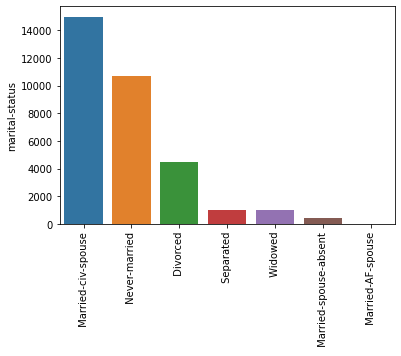

Graph for occupation: total = 15


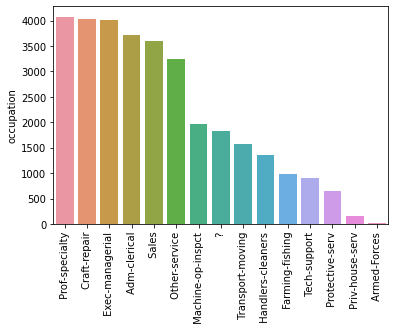

Graph for relationship: total = 6


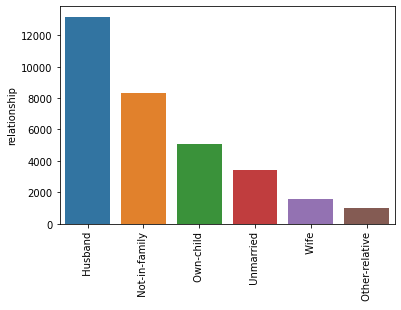

Graph for race: total = 5


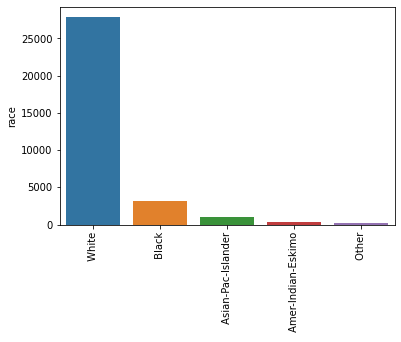

Graph for sex: total = 2


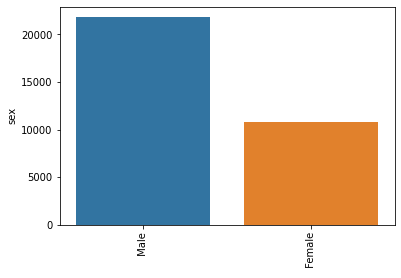

Graph for native-country: total = 42


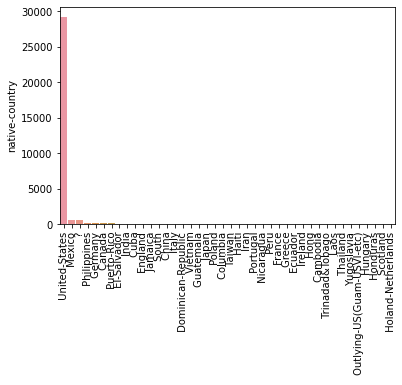

In [9]:
import seaborn as sns

# Categorical variables
df_categorical = df[['workclass',
                    'education',
                    'marital-status',
                    'occupation',
                    'relationship',
                    'race',
                    'sex',
                    'native-country'
                    ]]

for i in df_categorical.columns:
    cat_num = df_categorical[i].value_counts()
    print("Graph for %s: total = %d" % (i,len(cat_num)))
    chart = sns.barplot(x = cat_num.index, y = cat_num)
    chart.set_xticklabels(chart.get_xticklabels(),rotation = 90)
    plt.show()

Train the model to predict if salary will be above 50k.

In [15]:
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
procs = [FillMissing, Categorify, Normalize]

In [17]:
test = TabularList.from_df(df.iloc[800:1000].copy(), path=path, cat_names=cat_names, cont_names=cont_names)

In [18]:
data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(800,1000)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [19]:
data.show_batch(rows=10)

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target
Private,HS-grad,Widowed,Sales,Not-in-family,White,Female,United-States,False,1.4229,-0.2523,-0.4224,-0.1459,-0.2164,-0.4406,>=50k
State-gov,Doctorate,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,False,2.2292,0.1266,2.3157,-0.1459,-0.2164,0.7743,>=50k
Self-emp-not-inc,Bachelors,Divorced,Exec-managerial,Unmarried,Black,Female,United-States,False,-0.4828,0.7342,1.1422,-0.1459,-0.2164,-0.8456,<50k
Self-emp-not-inc,Assoc-voc,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,False,0.1769,-1.4903,0.3599,-0.1459,-0.2164,0.3694,<50k
Self-emp-not-inc,HS-grad,Never-married,Craft-repair,Not-in-family,White,Male,United-States,False,0.7632,-0.6269,-0.4224,-0.1459,-0.2164,-0.8456,<50k
Private,Some-college,Never-married,Sales,Own-child,White,Female,United-States,False,-1.1425,-0.7304,-0.0312,-0.1459,-0.2164,-2.3036,<50k
Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,False,-0.1896,-0.1924,-0.4224,0.8396,-0.2164,-0.0356,>=50k
Private,11th,Never-married,Farming-fishing,Own-child,White,Male,United-States,False,-1.4357,-0.5064,-1.2046,-0.1459,-0.2164,-1.3316,<50k
?,HS-grad,Married-civ-spouse,?,Husband,White,Male,United-States,False,-0.3362,-1.2685,-0.4224,-0.1459,-0.2164,-0.0356,<50k
Private,Bachelors,Divorced,Adm-clerical,Unmarried,White,Female,United-States,False,-0.5561,-0.6714,1.1422,-0.1459,-0.2164,0.3694,<50k


In [20]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)
#                          architecture like resnet    metrics

In [21]:
learn.fit(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.326549,0.362220,0.850000,00:08


In [22]:
learn.save('stage-1')

In [39]:
#exporting model
learn.export()

## Inference

In [23]:
#Now try to use this model to predict on the entire adults.csv file
tabList = TabularList(df, cat_names=cat_names, cont_names=cont_names, procs=procs)

In [38]:
#learner = load_learner(path, test=test)

#Works
for i in range(200):
    row = df.iloc[800 + i]
    print(learn.predict(row))

(Category tensor(0), tensor(0), tensor([0.9665, 0.0335]))
(Category tensor(1), tensor(1), tensor([0.1915, 0.8085]))
(Category tensor(0), tensor(0), tensor([0.9271, 0.0729]))
(Category tensor(0), tensor(0), tensor([0.9517, 0.0483]))
(Category tensor(0), tensor(0), tensor([0.6264, 0.3736]))
(Category tensor(0), tensor(0), tensor([0.5840, 0.4160]))
(Category tensor(0), tensor(0), tensor([0.6861, 0.3139]))
(Category tensor(0), tensor(0), tensor([0.9913, 0.0087]))
(Category tensor(0), tensor(0), tensor([0.9876, 0.0124]))
(Category tensor(0), tensor(0), tensor([0.6811, 0.3189]))
(Category tensor(1), tensor(1), tensor([0.2998, 0.7002]))
(Category tensor(1), tensor(1), tensor([0.3111, 0.6889]))
(Category tensor(0), tensor(0), tensor([0.8201, 0.1799]))
(Category tensor(0), tensor(0), tensor([0.8005, 0.1995]))
(Category tensor(0), tensor(0), tensor([0.9859, 0.0141]))
(Category tensor(0), tensor(0), tensor([0.6708, 0.3292]))
(Category tensor(0), tensor(0), tensor([0.6396, 0.3604]))
(Category tens